# CDS6214-DATA SCIENCE FUNDAMENTALS Project TT10L Group I

# Transportation Project <br>
Title : Used Car Price Prediction


#### Group I

**Tutorial section: TT10_L**


| | Student ID     | Student Name                | Contribution | 
|--:|:-------------|:----------------------------|-------------:|
| 1 | 242UC24511   | Chan Jia Jun                | 33%          | 
| 2 | 242UC24513   | Chen Yong Qi                | 30%          | 
| 3 | 242UC24515   | Tong Jian Hao               | 37%          | 


# **Objective**
1. Data Pre-processing / Cleaning
2. Data Analysis/Statistical Study
3. Modelling (2 models: RandomForest, XGBoost)  
4. Knowledge Evaluation

# Exploratory Questions
Here are the four exploratory questions questions that we address in our project Exploratory Data Analysis:
1. **Q1:** How do service history and mileage efficiency affect used car prices?
2. **Q2:** How can manufacturers or resellers adapt to the trend of engine sizes in recent years to better match consumer demand?
3. **Q3:** Are certain car colors more frequently associated with accident reports?  
4. **Q4:** Do economy cars tend to have more owners than higher-end cars over the years?

Imports & Load Data

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, linregress, chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, ConfusionMatrixDisplay
)
# Load the dataset
df = pd.read_csv('used_car_price_dataset_extended.csv')
display(df)


,RowNumber,make_year,mileage_kmpl,engine_cc,fuel_type,owner_count,price_usd,brand,transmission,color,service_history,accidents_reported,insurance_valid
0,1,2001,8.17,4000,Petrol,4,8587.64,Chevrolet,Manual,White,NaN,0,No
1,2,2014,17.59,1500,Petrol,4,5943.50,Honda,Manual,Black,NaN,0,Yes
2,3,2023,18.09,2500,Diesel,5,9273.58,BMW,Automatic,Black,Full,1,Yes
3,4,2009,11.28,800,Petrol,1,6836.24,Hyundai,Manual,Blue,Full,0,Yes
4,5,2005,12.23,1000,Petrol,2,4625.79,Nissan,Automatic,Red,Full,0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,1996,15.25,1500,Petrol,2,5498.71,Hyundai,Manual,Silver,NaN,0,Yes
9996,9997,1997,14.45,5000,Diesel,1,9588.31,Honda,Manual,Gray,Full,0,Yes
9997,9998,2002,19.41,1000,Diesel,4,4557.10,Kia,Manual,Black,Full,0,Yes
9998,9999,2005,12.95,4000,Petrol,5,7413.59,BMW,Automatic,Blue,Full,0,Yes


Inspect & Clean

In [83]:
# Missing values
print("Missing values per column:\n", df.isnull().sum())

# Normalize service_history values (handle missing/blank as 'None')
df['service_history'] = df['service_history'].fillna('None')                   # Replace NaN
df['service_history'] = df['service_history'].replace(['', 'nan', 'NaN'], 'None')  # Replace empty strings
df['service_history'] = df['service_history'].str.strip().str.title()         # Standardize casing

# Drop exact duplicates
df.drop_duplicates(inplace=True)
print(f"Rows after deduplication: {len(df)}")

Missing values per column:
 RowNumber                0
make_year                0
mileage_kmpl             0
engine_cc                0
fuel_type                0
owner_count              0
price_usd                0
brand                    0
transmission             0
color                    0
service_history       2038
accidents_reported       0
insurance_valid          0
dtype: int64
Rows after deduplication: 10000


Show Raw Data

In [84]:
display(df.head().transpose())

num_rows, num_columns = df.shape
print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_columns}")

,0,1,2,3,4
RowNumber,1,2,3,4,5
make_year,2001,2014,2023,2009,2005
mileage_kmpl,8.17,17.59,18.09,11.28,12.23
engine_cc,4000,1500,2500,800,1000
fuel_type,Petrol,Petrol,Diesel,Petrol,Petrol
owner_count,4,4,5,1,2
price_usd,8587.64,5943.5,9273.58,6836.24,4625.79
brand,Chevrolet,Honda,BMW,Hyundai,Nissan
transmission,Manual,Manual,Automatic,Manual,Automatic
color,White,Black,Black,Blue,Red


Number of rows: 10000
Number of columns: 13


Summary Stats

In [85]:
summary_stats = df.describe().transpose()
display(summary_stats)

,count,mean,std,min,25%,50%,75%,max
RowNumber,10000.0,5000.500000,2886.895680,1.0,2500.7500,5000.50,7500.2500,10000.00
make_year,10000.0,2009.206900,8.373858,1995.0,2002.0000,2009.00,2016.0000,2023.00
mileage_kmpl,10000.0,17.960753,5.025486,5.0,14.5400,17.97,21.3525,35.00
engine_cc,10000.0,2287.130000,1291.276927,800.0,1200.0000,1800.00,3000.0000,5000.00
owner_count,10000.0,3.003500,1.418904,1.0,2.0000,3.00,4.0000,5.00
price_usd,10000.0,7179.754532,2795.270940,1000.0,5176.5475,6961.26,8993.7325,17647.63
accidents_reported,10000.0,0.492200,0.694109,0.0,0.0000,0.00,1.0000,5.00


# Question 1 : How do service history and mileage efficiency affect used car prices?

# 🔧 Data Pre-processing / Cleaning

In [86]:
# Keep all service history values including 'None'
df_q1 = df[['price_usd', 'service_history', 'mileage_kmpl']].dropna()
df_q1['service_history'] = df_q1['service_history'].str.strip().str.title()

# Bin mileage into Low, Medium, High
df_q1['mileage_group'] = pd.qcut(df_q1['mileage_kmpl'], q=3, labels=['Low', 'Medium', 'High'])

# Group by service history (including None) and mileage group
avg_price_grouped = df_q1.groupby(['service_history', 'mileage_group'], observed=True)['price_usd'].mean().unstack()

df['service_history'].value_counts()


service_history
Full       4987
Partial    2975
None       2038
Name: count, dtype: int64

# 📊 Data Analysis / Statistical Study

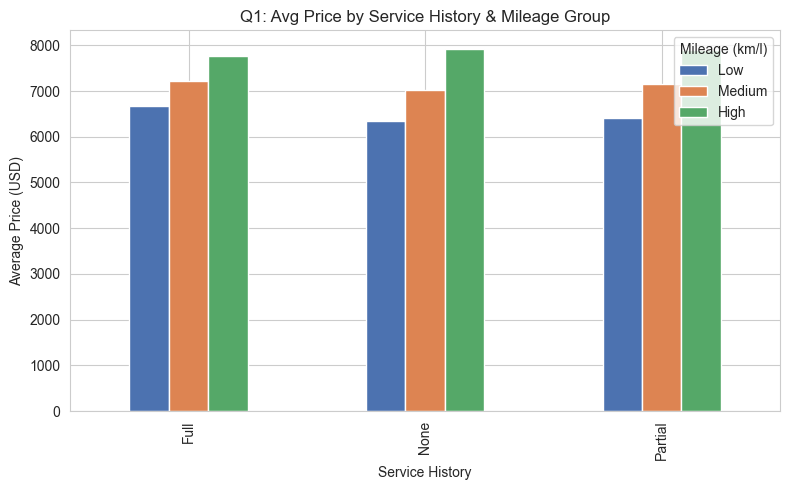

In [99]:
custom_colors = ['#4C72B0', '#DD8452', '#55A868']  # blue, orange, green

ax = avg_price_grouped.plot(kind='bar', figsize=(8, 5), color=custom_colors)
plt.title("Q1: Avg Price by Service History & Mileage Group")
plt.xlabel("Service History")
plt.ylabel("Average Price (USD)")
plt.legend(title='Mileage (km/l)')
plt.tight_layout()
plt.show()

# Question 2 : How can manufacturers or resellers adapt to the trend of engine sizes in recent years to better match consumer demand?

# 🔧 Data Pre-processing / Cleaning

In [88]:
df_q2 = df[['make_year','engine_cc']].dropna()
df_q2['make_year'] = df_q2['make_year'].astype(int)

# 📊 Data Analysis / Statistical Study

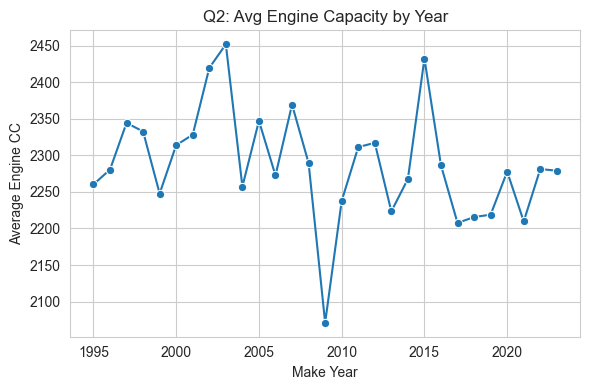

In [89]:
trend = df_q2.groupby('make_year')['engine_cc'].mean()
plt.figure(figsize=(6,4))
sns.lineplot(x=trend.index, y=trend.values, marker='o')
plt.title("Q2: Avg Engine Capacity by Year")
plt.xlabel("Make Year")
plt.ylabel("Average Engine CC")
plt.grid(True)
plt.tight_layout()
plt.show()

# Question 3 : Are certain car colors more frequently associated with accident reports?

# 🔧 Data Pre-processing / Cleaning

In [90]:
df_q3 = df[['color','accidents_reported','brand','make_year','transmission']].dropna()
df_q3['color']      = df_q3['color'].str.strip().str.title()
df_q3['has_accident']= (df_q3['accidents_reported'] > 0).astype(int)

# 📊 Data Analysis / Statistical Study

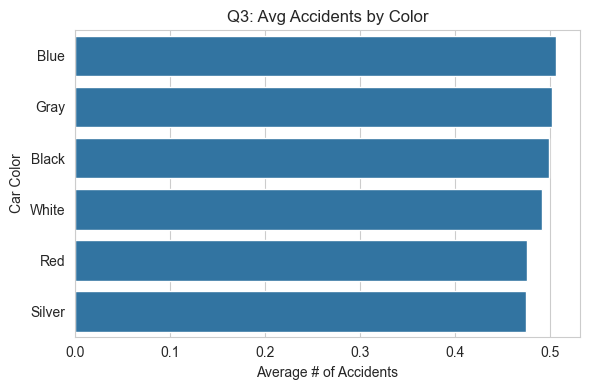

In [91]:
avg_acc_by_color = df_q3.groupby('color')['accidents_reported'].mean().sort_values(ascending=False)
plt.figure(figsize=(6,4))
sns.barplot(x=avg_acc_by_color.values, y=avg_acc_by_color.index)
plt.title("Q3: Avg Accidents by Color")
plt.xlabel("Average # of Accidents")
plt.ylabel("Car Color")
plt.tight_layout()
plt.show()

# Question 4 : Do economy cars tend to have more owners than higher-end cars over the years?

# 🔧 Data Pre-processing / Cleaning

In [92]:
economy = ['Toyota','Honda','Hyundai','Nissan','Kia']
luxury  = ['Bmw','Mercedes-Benz','Audi','Lexus','Porsche']
df_q4 = df[['make_year','owner_count','brand']].dropna()
df_q4['brand'] = df_q4['brand'].str.strip().str.title()
df_q4['category'] = df_q4['brand'].apply(
    lambda b: 'Economy' if b in economy else ('High-End' if b in luxury else 'Other')
)
df_q4 = df_q4[df_q4['category'].isin(['Economy','High-End'])]

# 📊 Data Analysis / Statistical Study

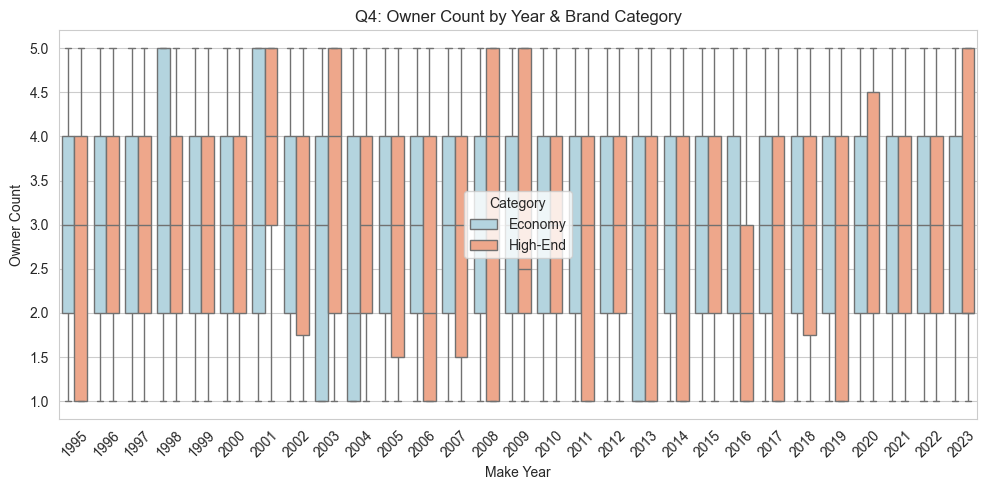

In [93]:
# Create boxplot with custom colors
plt.figure(figsize=(10, 5))
sns.set_style("whitegrid")
palette = {"Economy": "#ADD8E6", "High-End": "#FFA07A"}
sns.boxplot(data=df_q4, x='make_year', y='owner_count', hue='category', palette=palette, showfliers=False)

plt.title("Q4: Owner Count by Year & Brand Category")
plt.xlabel("Make Year")
plt.ylabel("Owner Count")
plt.xticks(rotation=45)
plt.legend(title='Category')
plt.tight_layout()
plt.show()


# Modelling

## 🔧 Modeling
This section includes training a Random Forest Regressor to predict the price of used cars based on features such as brand, mileage, and engine size.

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

# Prepare data
df_model = df.copy()
target = "price_usd"
drop_cols = ['RowNumber']
df_model.drop(columns=drop_cols, inplace=True)

# Encode categorical features
categorical_cols = df_model.select_dtypes(include='object').columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    label_encoders[col] = le

# Split dataset
X = df_model.drop(columns=[target])
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 📈 Evaluation
We evaluate the model's performance using Mean Squared Error (MSE) and R² Score to assess its prediction accuracy.

In [95]:
# Train model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error: 1486082.94
R² Score: 0.8132


In [96]:
from sklearn.model_selection import cross_val_score
bins = np.quantile(y_train, [0, 0.33, 0.66, 1.0])
labels = ['Low', 'Medium', 'High']

y_train_cat = pd.cut(y_train, bins=bins, labels=labels, include_lowest=True)
y_test_cat  = pd.cut(y_test,  bins=bins, labels=labels, include_lowest=True)

# Train a RandomForestClassifier on the binned labels
rf_clf   = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scores = cross_val_score(rf_clf, X_train, y_train_cat, cv=5, scoring='f1_macro')
f1_mean   = cv_scores.mean()
f1_sd     = cv_scores.std()

rf_clf.fit(X_train, y_train_cat)
y_pred_cat = rf_clf.predict(X_test)

# Compute test‐set metrics
test_acc  = accuracy_score(y_test_cat, y_pred_cat)
test_prec = precision_score(y_test_cat, y_pred_cat, average='macro')
test_rec  = recall_score(y_test_cat, y_pred_cat, average='macro')
test_f1   = f1_score(y_test_cat, y_pred_cat, average='macro')

# Assemble into a DataFrame
metrics_df = pd.DataFrame([{
    'Model':           'RandomForest',
    'F1_Mean':         f1_mean,
    'F1_SD':           f1_sd,
    'Test_Accuracy':   test_acc,
    'Test_Precision':  test_prec,
    'Test_Recall':     test_rec,
    'Test_F1':         test_f1
}])

# Display 
display(metrics_df.set_index('Model'))

NameError: name 'np' is not defined

## 📊 Feature Importance Visualization
The bar chart below shows which features had the most impact on predicting car prices.

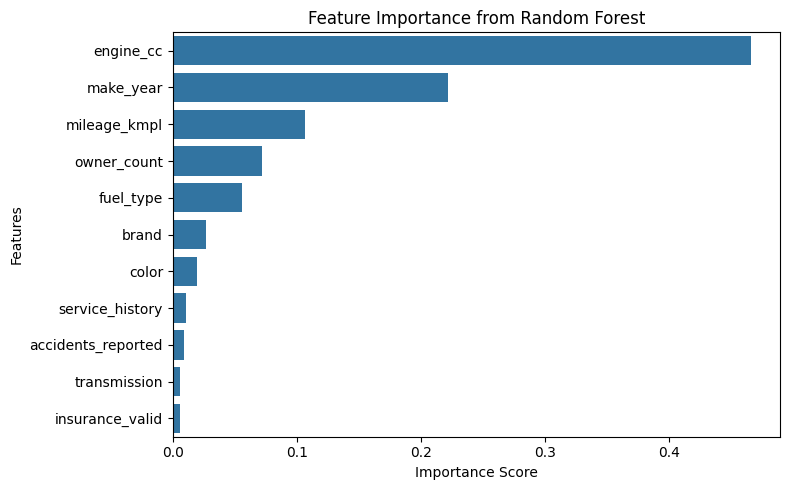

In [ ]:
# Feature importance
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

feature_importance = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title("Feature Importance from Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

Build & sort the feature-importance DataFrame as before and print as a table

In [ ]:
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
})
feature_importances = (
    feature_importances
    .sort_values('Importance', ascending=False)
    .reset_index(drop=True)
)

feature_importances = feature_importances.set_index('Feature')

display(feature_importances)

,Importance
Feature,
engine_cc,0.466151
make_year,0.221679
mileage_kmpl,0.106777
owner_count,0.071561
fuel_type,0.056157
brand,0.026855
color,0.019663
service_history,0.010477
accidents_reported,0.008954
